# This ML script would not have been possible without inspiration from, github user ***'wiamsuri'*** and their project ***'cnn-image-classifier-keras'***

In [143]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
# from PIL import ImageFile
import random
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
import pandas as pd
import shutil

# Load Images From File

In [22]:
image_names = sorted(os.listdir('resources/data_for_training_06'))
number_of_image_categories = len(image_names)
print('%d image categories.' % number_of_image_categories)
print('Three categories:')
print(image_names[:3])

3 image categories.
Three categories:
['brick_10', 'siding_20', 'unknown_00']


In [175]:
def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), number_of_image_categories)
    return image_files, image_targets

image_files, image_targets = load_dataset('resources/data_for_training_06/')

trains_validate_files, test_files, trains_validate_targets, test_targets = \
    train_test_split(image_files, image_targets, test_size=0.2, random_state=42)

train_files, valid_files, train_targets, valid_targets = \
    train_test_split(trains_validate_files, trains_validate_targets, test_size=0.25, random_state=42)

print(image_names)

print('%s images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print(train_files[:10])
print('%d training images.' % len(train_files))
print(valid_files[:10])
print('%d validation images.' % len(valid_files))
print(test_files[:10])
print('%d test images.'% len(test_files))

# print(train_targets[:10])
# print(valid_tensors[:10])

['brick_10', 'siding_20', 'unknown_00']
4105 images.

['resources/data_for_training_06/brick_10\\10_13306.jpeg'
 'resources/data_for_training_06/brick_10\\10_13167.jpeg'
 'resources/data_for_training_06/siding_20\\20_14522.jpg'
 'resources/data_for_training_06/siding_20\\20_11301.jpg'
 'resources/data_for_training_06/siding_20\\20_9303.jpg'
 'resources/data_for_training_06/siding_20\\20_11887.jpg'
 'resources/data_for_training_06/brick_10\\10_13271.jpeg'
 'resources/data_for_training_06/brick_10\\10_13018.jpeg'
 'resources/data_for_training_06/brick_10\\10_9747.jpeg'
 'resources/data_for_training_06/brick_10\\10_12591.jpeg']
2463 training images.
['resources/data_for_training_06/brick_10\\10_13163.jpeg'
 'resources/data_for_training_06/brick_10\\10_12536.jpeg'
 'resources/data_for_training_06/brick_10\\10_13398.jpeg'
 'resources/data_for_training_06/brick_10\\10_9143.jpeg'
 'resources/data_for_training_06/brick_10\\10_9098.jpeg'
 'resources/data_for_training_06/siding_20\\20_11353.jpg'

# Define function for preprocessing images

In [24]:
def path_to_tensor(img_path):

    img = image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(400, 400), interpolation="nearest")
    img_array = image.img_to_array(img)

    return np.expand_dims(img_array, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Preprocess images

In [25]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 821/821 [00:05<00:00, 162.72it/s]


# Build Model

In [26]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=2, padding='same',
                 activation='relu', input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))



model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))


model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 400, 400, 4)       52        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 200, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 8)       136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 12)      396       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 12)        0

# Train the model with training and validating images

In [27]:
epochs = 15

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.image_classifier.hdf5',
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Epoch 1/15
39/39 [==============================] - ETA: 0s - loss: 1.5226 - accuracy: 0.4564
Epoch 00001: val_loss improved from inf to 1.00772, saving model to saved_models\weights.best.image_classifier.hdf5
39/39 [==============================] - 46s 1s/step - loss: 1.5226 - accuracy: 0.4564 - val_loss: 1.0077 - val_accuracy: 0.4348
Epoch 2/15
39/39 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.5388
Epoch 00002: val_loss did not improve from 1.00772
39/39 [==============================] - 48s 1s/step - loss: 0.9272 - accuracy: 0.5388 - val_loss: 1.0265 - val_accuracy: 0.4872
Epoch 3/15
39/39 [==============================] - ETA: 0s - loss: 0.8597 - accuracy: 0.5920
Epoch 00003: val_loss improved from 1.00772 to 0.90672, saving model to saved_models\weights.best.image_classifier.hdf5
39/39 [==============================] - 48s 1s/step - loss: 0.8597 - accuracy: 0.5920 - val_loss: 0.9067 - val_accuracy: 0.6248
Epoch 4/15
39/39 [==========================

In [28]:
model.load_weights('saved_models/epochs20_80pct_accuracy/weights.best.image_classifier.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.9220%


In [42]:
print("brick images:")
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (400,400,3))
    predictions = model.predict(np.array([resized_image]))
    if image.split("_")[0] == "brick":
        print(image, predictions)
print()
print("siding images:")
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (400,400,3))
    predictions = model.predict(np.array([resized_image]))
    if image.split("_")[0] == "siding":
        print(image, predictions)

print()
print("unknown images:")
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (400,400,3))
    predictions = model.predict(np.array([resized_image]))
    if image.split("_")[0] == "unknown":
        print(image, predictions)

#['brick_10/', 'siding_20/', 'unknown_00/']

brick images:
brick_5901.jpg [[0.24670175 0.22625571 0.5270425 ]]
brick_5902.jpg [[0.40912455 0.22354878 0.36732662]]
brick_62.jpg [[0.8633684  0.02888038 0.10775126]]
brick_6449.jpg [[0.30088088 0.30828375 0.39083531]]
brick_7266.jpg [[0.919009   0.01378137 0.06720964]]
brick_7664.jpg [[0.8254461  0.02773851 0.14681534]]
brick_7839.jpg [[0.5870504  0.04984181 0.36310783]]
brick_81.jpg [[0.6525984  0.19034024 0.15706135]]

siding images:
siding_6450.jpg [[0.19676615 0.4065325  0.39670134]]
siding_6672.jpg [[0.15936013 0.16347688 0.677163  ]]
siding_7135.jpg [[0.55190414 0.33770177 0.11039411]]
siding_7271.jpg [[0.3276643  0.3164837  0.35585207]]
siding_7488.jpg [[0.17436261 0.45886362 0.36677372]]
siding_7493.jpg [[0.26932433 0.55915225 0.17152347]]
siding_7494.jpg [[0.27336484 0.55709666 0.16953851]]
siding_7581.jpg [[0.20074686 0.34373212 0.45552096]]
siding_7669.jpg [[0.26087093 0.09778666 0.6413424 ]]

unknown images:
unknown_6673.jpg [[0.3015581 0.2739814 0.4244605]]
unknown_6675.

In [110]:
def model_guess(path, house_type): #brick, siding, or unknown
    classification = ['brick', 'siding', 'unknown']
    print()
    print(f'Predictions for {house_type}: Percentage accuracy of model versus a human')
    print()
    index = classification.index(house_type)
    correct = 0
    wrong = 0
    total_images = 0
    for image in os.listdir(path):  
        if image.split("_")[0] == house_type:
            total_images += 1
            img = plt.imread('test_imgs' + '/' + image)
            resized_image = resize(img, (400,400,3))
            predictions = model.predict(np.array([resized_image]))
            if predictions[0][index] == predictions[0].max():
                print(f"\n{image}: Correct")
                correct += 1
            else:
                print(f"\n{image}: Wrong")
                wrong += 1
            for i, prediction in enumerate(predictions[0]):
                print('\t',classification[i], round(100*prediction,0),'%')
    print()
    print('Stats:')
    print('\tTotal images:', total_images)
    print('\tAccuracy:', round(100*correct/(correct+wrong),0),'%')
    print('\tCorrect:', correct)
    print('\tWrong:', wrong)

In [111]:
model_guess('test_imgs', 'brick')


Predictions for brick: Percentage accuracy of model versus a human


brick_5901.jpg: Wrong
	 brick 25.0 %
	 siding 23.0 %
	 unknown 53.0 %

brick_5902.jpg: Correct
	 brick 41.0 %
	 siding 22.0 %
	 unknown 37.0 %

brick_62.jpg: Correct
	 brick 86.0 %
	 siding 3.0 %
	 unknown 11.0 %

brick_6449.jpg: Wrong
	 brick 30.0 %
	 siding 31.0 %
	 unknown 39.0 %

brick_7266.jpg: Correct
	 brick 92.0 %
	 siding 1.0 %
	 unknown 7.0 %

brick_7664.jpg: Correct
	 brick 83.0 %
	 siding 3.0 %
	 unknown 15.0 %

brick_7839.jpg: Correct
	 brick 59.0 %
	 siding 5.0 %
	 unknown 36.0 %

brick_81.jpg: Correct
	 brick 65.0 %
	 siding 19.0 %
	 unknown 16.0 %

Stats:
	Total images: 8
	Accuracy: 75.0 %
	Correct: 6
	Wrong: 2


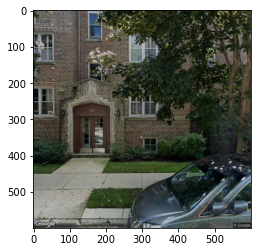

In [31]:
new_image = plt.imread('test_imgs/brick_62.jpg')
img = plt.imshow(new_image)

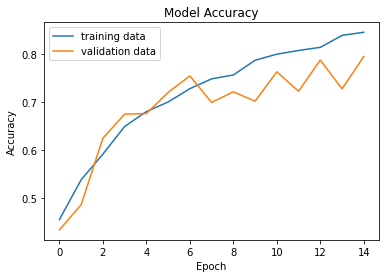

In [98]:
#Visualize the model's accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='upper left')
plt.show()

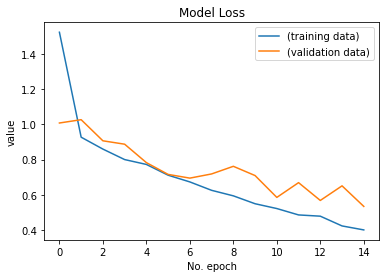

<Figure size 432x288 with 0 Axes>

In [176]:
# Plot history: 
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(validation data)')
plt.title('Model Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
plt.savefig('65pct.png')

# Below Code Needs Significant Modification to Run

In [ ]:


# """ order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.

# This can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:"""

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

In [172]:
# """These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

# rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
# width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
# shear_range is for randomly applying shearing transformations.
# zoom_range is for randomly zooming inside pictures.
# horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
# fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift."""

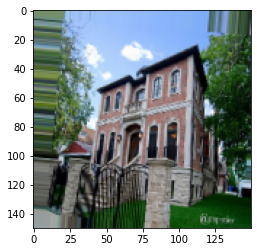

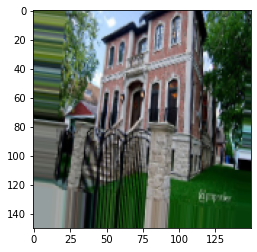

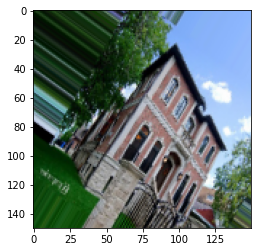

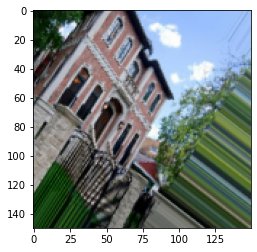

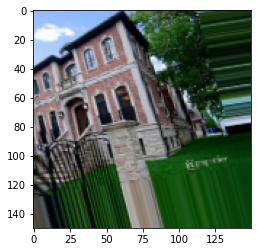

In [139]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# img_path = os.path.join('resources/data_for_training_06/brick_10\\10_13306.jpeg')
# img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# # The .flow() command below generates batches of randomly transformed images
# # It will loop indefinitely, so we need to `break` the loop at some point!
# i = 0
# for batch in datagen.flow(x, batch_size=1):
#   plt.figure(i)
#   imgplot = plt.imshow(array_to_img(batch[0]))
#   i += 1
#   if i % 5 == 0:
#     break

In [163]:
# def my_alternative_validation_split_method(main_dir_path, split=0.2):
    
#     shutil.copytree(main_dir_path, main_dir_path + '_alt')
    
#     main_dir_path = main_dir_path + '_alt'
#     train_path = main_dir_path + '/train'
#     validation_path = main_dir_path + '/validate'
    
#     if os.path.isdir(train_path) or os.path.isdir(validation_path):
#         print('You have already split your training and test data')
        
#     else:
#         sub_dir_names = os.listdir(main_dir_path)
#         os.mkdir(train_path)
#         os.mkdir(validation_path)
#         for sub_dir_name in sub_dir_names:
#             name = sub_dir_name.split('_')[0]
#             os.mkdir(train_path + '/'+ name)
#             os.mkdir(validation_path + '/'+ name)
#             images = os.listdir(main_dir_path +'/' + sub_dir_name)
#             val_n = int(split * len(images))
#             val_images = images[:val_n]
#             for i in range(len(val_images)):
#                 for filepath in glob(main_dir_path +'/' + sub_dir_name + '/' + val_images[i]):
#                     shutil.move(main_dir_path +'/' + sub_dir_name + '/' + val_images[i], validation_path +'/' + name + '/' + val_images[i])
#             training_images = os.listdir(main_dir_path +'/' + sub_dir_name)
#             print(f'{name}: {len(images)} total images')
#             print(f'{name}: {len(training_images)} training images')
#             print(f'{name}: {val_n} validation images')
#             print('validation split: ', 100 * round(val_n/(val_n + len(training_images)),2), '%')
#             print()
#             for i in range(len(training_images)):
#                 for filepath in glob(main_dir_path +'/' + sub_dir_name + '/' + training_images[i]):
#                     shutil.move(main_dir_path +'/' + sub_dir_name + '/' + training_images[i], train_path +'/' + name + '/' + training_images[i])
#         for sub_dir_name in sub_dir_names:
#             os.rmdir(main_dir_path +'/' + sub_dir_name)

In [165]:
# main_dir = 'resources/data_for_training_06'

# my_alternative_validation_split_method(main_dir, split=0.2)

brick: 1872 total images
brick: 1498 training images
brick: 374 validation images
validation split:  20.0 %

siding: 1529 total images
siding: 1224 training images
siding: 305 validation images
validation split:  20.0 %

unknown: 704 total images
unknown: 564 training images
unknown: 140 validation images
validation split:  20.0 %



In [167]:
# # Adding rescale, rotation_range, width_shift_range, height_shift_range,
# # shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,)

# # Note that the validation data should not be augmented!
# val_datagen = ImageDataGenerator(rescale=1./255)

# # Flow training images in batches of 32 using train_datagen generator
# train_generator = train_datagen.flow_from_directory(
#         main_dir + '_alt' + '/train',  # This is the source directory for training images
#         target_size=(400, 400),  
#         batch_size=20,
#         # Since we use binary_crossentropy loss, we need binary labels
#         class_mode='categorical')

# # Flow validation images in batches of 32 using val_datagen generator
# validation_generator = val_datagen.flow_from_directory(
#         main_dir + '_alt' + '/validate',
#         target_size=(400, 400),
#         batch_size=20,
#         class_mode='categorical')

Found 3286 images belonging to 3 classes.
Found 819 images belonging to 3 classes.


In [171]:
# model = Sequential()

# model.add(Conv2D(filters=4, kernel_size=2, padding='same',
#                  activation='relu', input_shape=(400, 400, 3)))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.3))



# model.add(Flatten())

# model.add(Dense(256, activation='relu'))

# model.add(Dropout(0.4))

# model.add(Dense(3, activation='softmax'))


# model.summary()

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# epochs = 15

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.image_classifier.hdf5',
#                                verbose=1, save_best_only=True)

# history = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)